In [1]:
import os
import sys
import numpy as np
import mne
mne.set_log_level('WARNING')

### Load Data

C:\Users\ra\AppData\Local\Temp\ipykernel_19780\910207557.py:6: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_bdf(filepath, preload=True)
C:\Users\ra\AppData\Local\Temp\ipykernel_19780\910207557.py:6: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_bdf(filepath, preload=True)


File duration: 28.08490833333333
Filename: Imagine_Pre_4025_220424


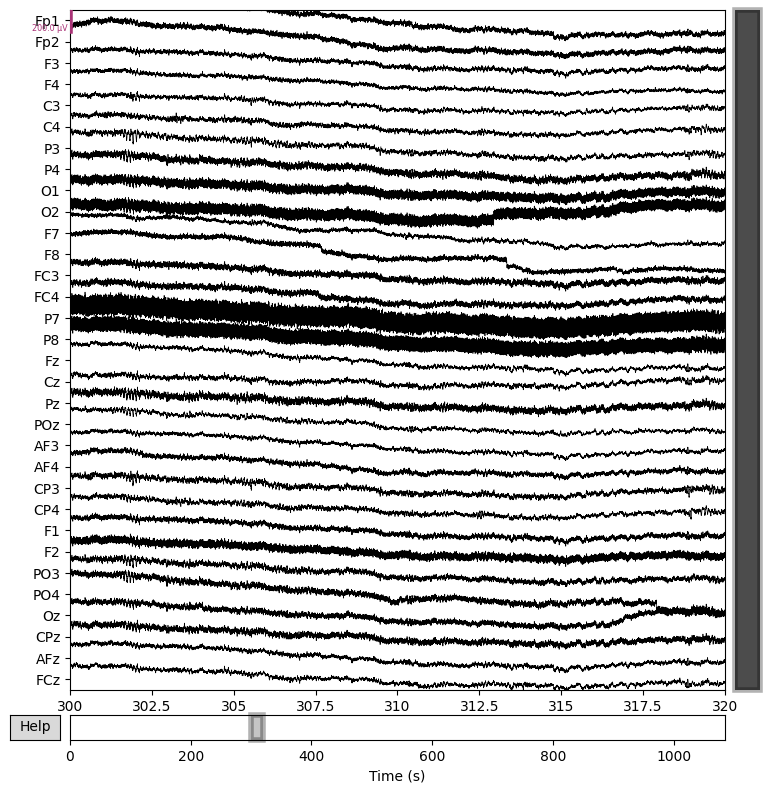

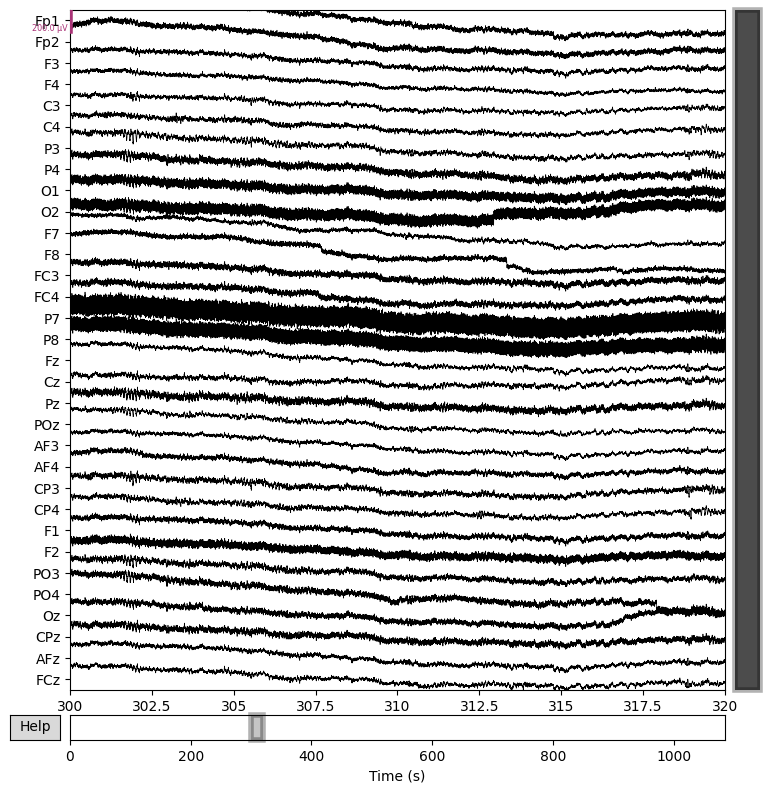

In [99]:
cwd = os.getcwd()
base_directory = os.path.join(cwd)

filename = 'Imagine_Pre_4025_220424'
filepath = os.path.join(base_directory, f"{filename}.bdf")
raw = mne.io.read_raw_bdf(filepath, preload=True)

eeg_channel_names = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'FC3', 'FC4', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'POz', 'AF3', 'AF4', 'CP3', 'CP4', 'F1', 'F2', 'PO3', 'PO4', 'Oz', 'CPz', 'AFz', 'FCz']

# Pick only EEG channels
raw.pick_channels(eeg_channel_names)

# Calculate the middle part of the recording
total_time_sec = raw.times[-1]  # total time in seconds
print(f'File duration: {total_time_sec/60}')

# start_time = (total_time_sec / 2) - (3600 / 2)  # Start time for 1-hour window centered at the middle
# end_time = (total_time_sec / 2) + (3600 / 2)  # End time for 1-hour window centered at the middle

#For shorter files (~ 30 mins)
start_time = 300  # 5 minutes * 60 seconds
end_time = total_time_sec - 300  # 5 minutes * 60 seconds from the end

# Crop the raw data
raw = raw.copy().crop(tmin=start_time, tmax=end_time)

#Resample to 512hz
raw = raw.copy().resample(512, n_jobs=60)

print(f'Filename: {filename}')

%matplotlib inline
# Plot the data
raw.plot(start=300, n_channels=32, scalings={'eeg': 1e-4}, show=False, block=False, use_opengl=True, precompute=True, duration=20)


In [26]:
# %matplotlib qt

# raw.plot(n_channels=32, scalings={'eeg': 1e-4}, show=False, block=False, use_opengl=True, precompute=True, duration=20)


### Remove ICs

C:\Users\ra\AppData\Local\Temp\ipykernel_19780\3804243702.py:17: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_eeg_only.interpolate_bads(reset_bads=True)


Plotting ICs for Imagine_Pre_4025_220424


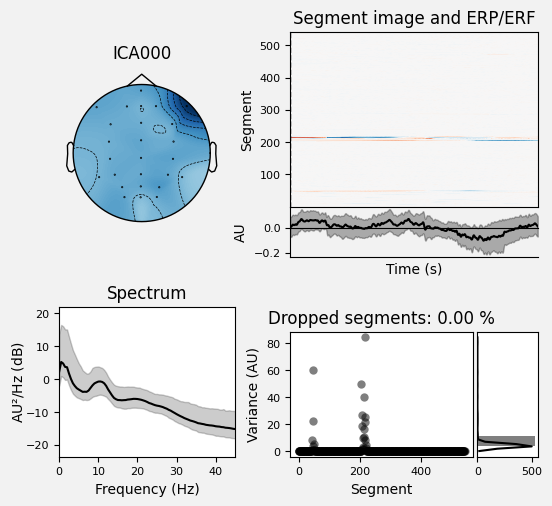

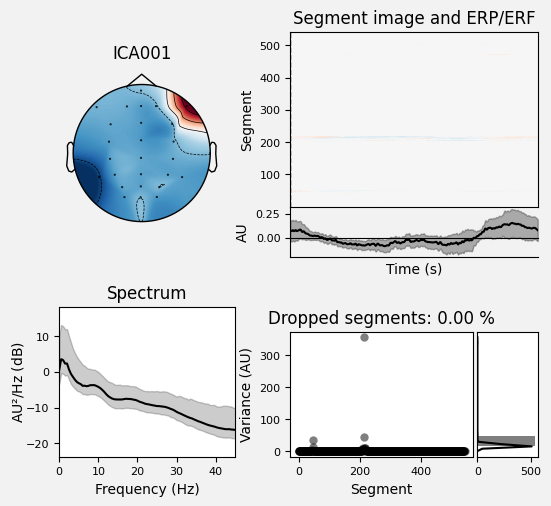

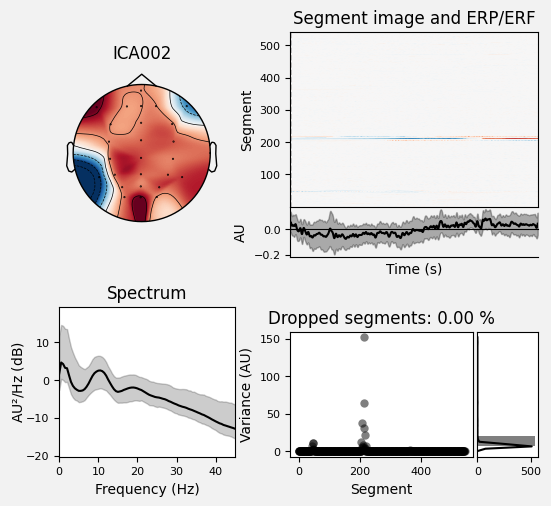

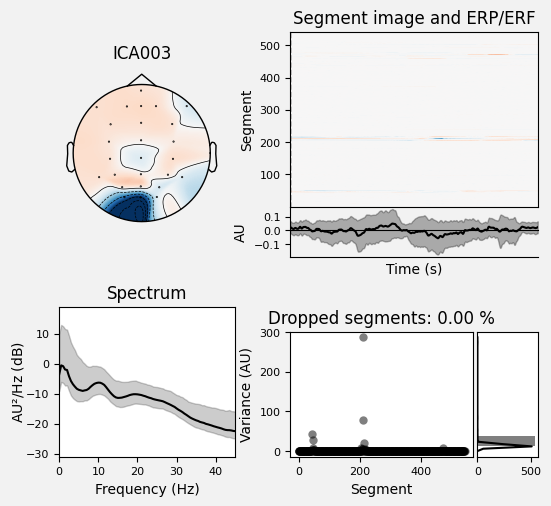

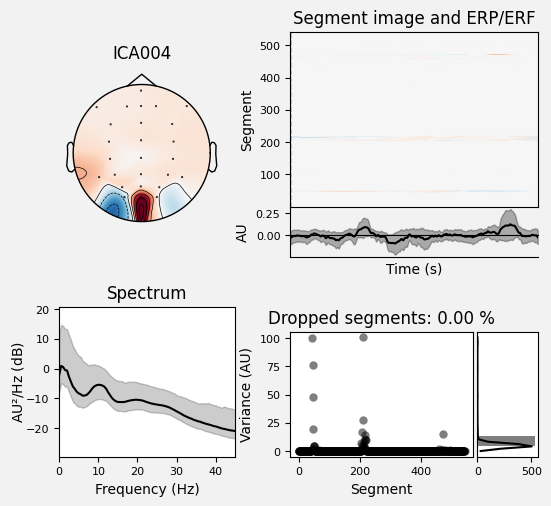

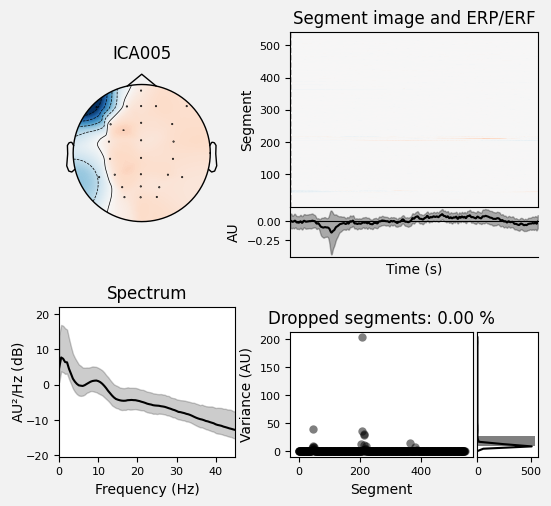

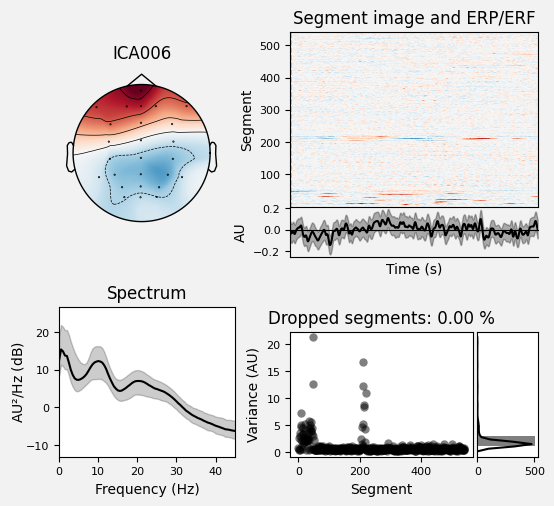

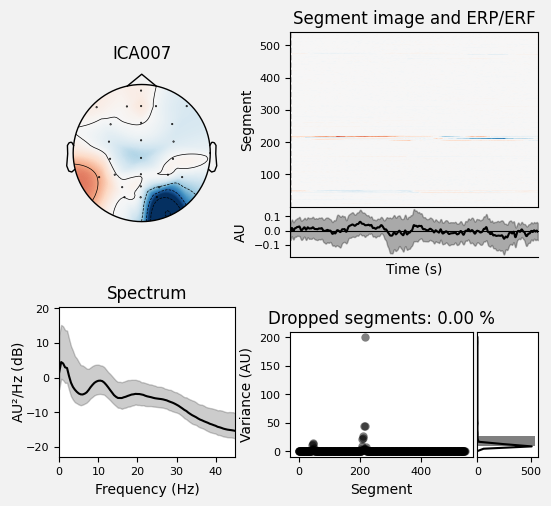

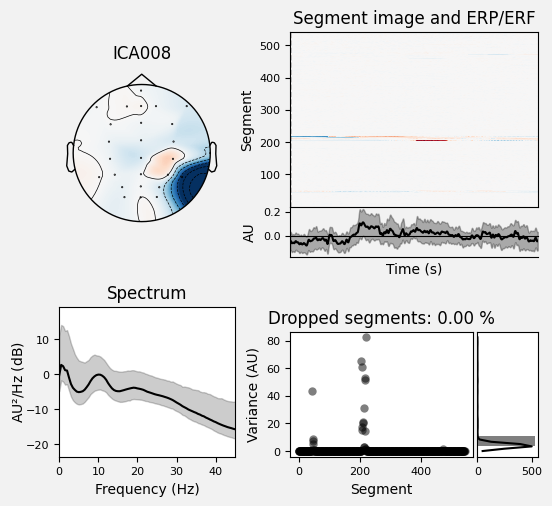

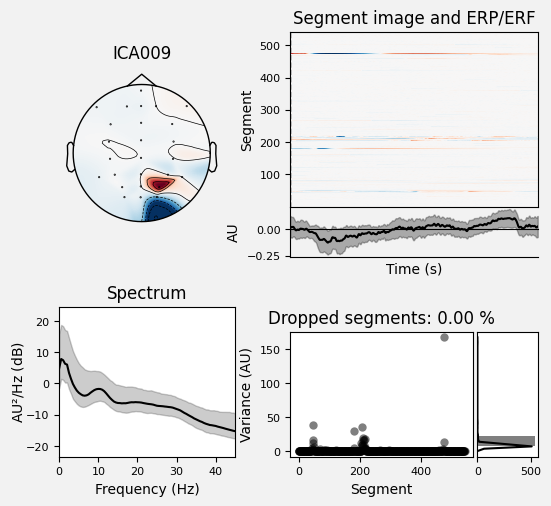

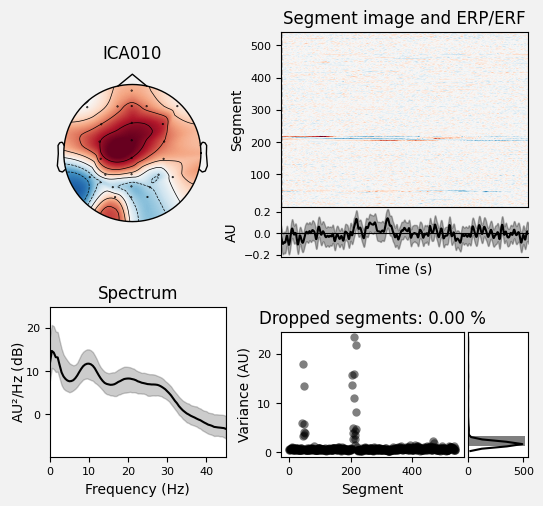

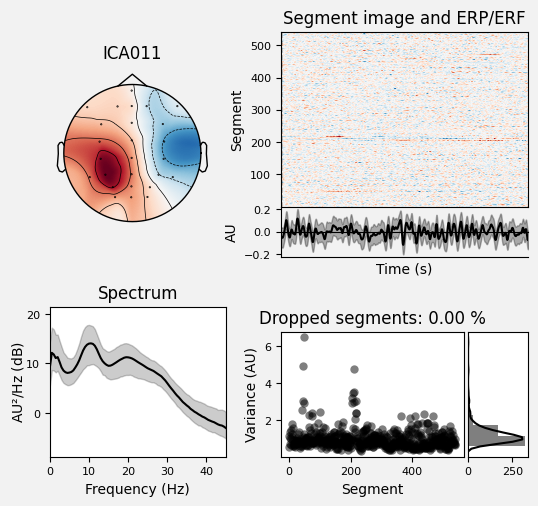

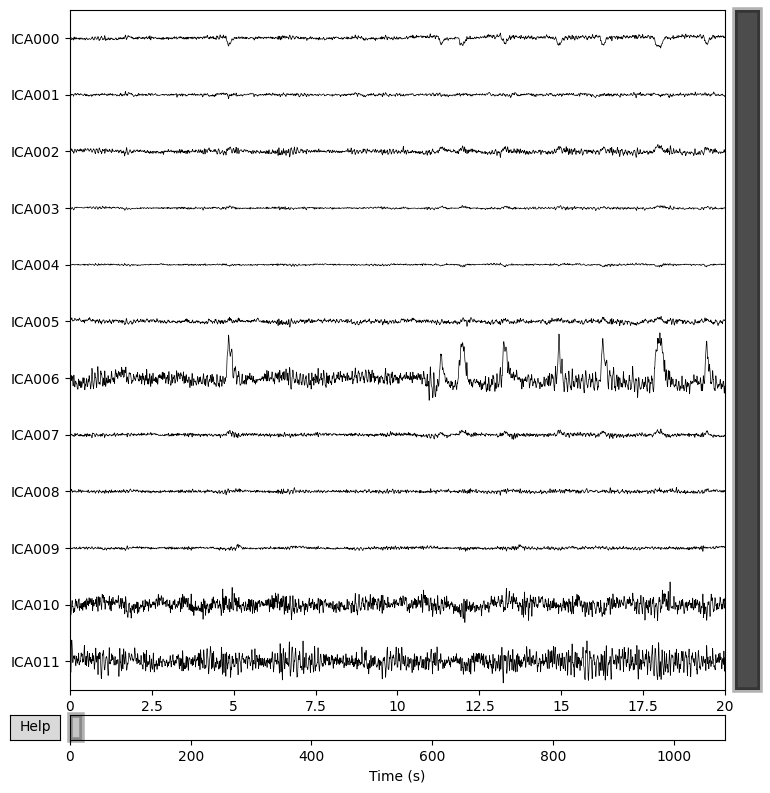

In [100]:
import joblib

def fit_ica(raw):
    raw = raw.copy()
    
    # Set montage
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage)

    # Apply bandpass filter
    raw.filter(0.5, 45, fir_design='firwin', n_jobs=60)

    # Select only EEG channels
    raw_eeg_only = raw
        
    # interpolate bad channels
    raw_eeg_only.interpolate_bads(reset_bads=True)

    # Set channel types for horizontal and vertical eye movements
    raw_eeg_only.set_channel_types({'F3': 'eog', 'F4': 'eog', 'Fp1': 'eog', 'AF3': 'eog', 'Fp2': 'eog', 'AF4': 'eog'})

    # Adjust ch_info to have three dictionary entries
    ch_info_list = [{'coil_type': 1}, {'coil_type': 1}, {'coil_type': 1}]

    # Set bipolar reference for horizontal and vertical eye movements
    mne.set_bipolar_reference(
        raw_eeg_only, 
        anode=['F3', 'Fp1', 'Fp2'], 
        cathode=['F4', 'AF3', 'AF4'], 
        ch_name=['hEOG', 'vEOG1', 'vEOG2'], 
        ch_info=ch_info_list, 
        copy=False
    )

    n_components = .99

    # Apply ICA in parallel
    ica = mne.preprocessing.ICA(n_components=n_components, method='fastica', random_state=42)
    with joblib.parallel_backend('multiprocessing', n_jobs=-1):
        ica.fit(raw_eeg_only)
    
    # Check for ICA convergence
    if ica.n_iter_ == ica.max_iter:
        print("Warning: ICA did not converge. You may want to increase 'max_iter' or try different ICA parameters.")
        
    return ica, raw_eeg_only

ica, raw = fit_ica(raw)

def plot_ICA_properties(ica, raw_eeg_only):
    n_components = ica.n_components_
    psd_args = {'fmax': 45, 'n_jobs': -1}

    other_inds = [i for i in range(n_components)]
    ica.plot_properties(inst=raw_eeg_only, picks=other_inds, psd_args=psd_args, show=True, figsize=[5.5,5])

print(f"Plotting ICs for {filename}")
%matplotlib inline
plot_ICA_properties(ica, raw)
        
%matplotlib qt
ica.plot_sources(raw.pick_types(eeg=True, eog=False), precompute=True, block=False, use_opengl=True)


Applying ICA for Imagine_Pre_4025_220424


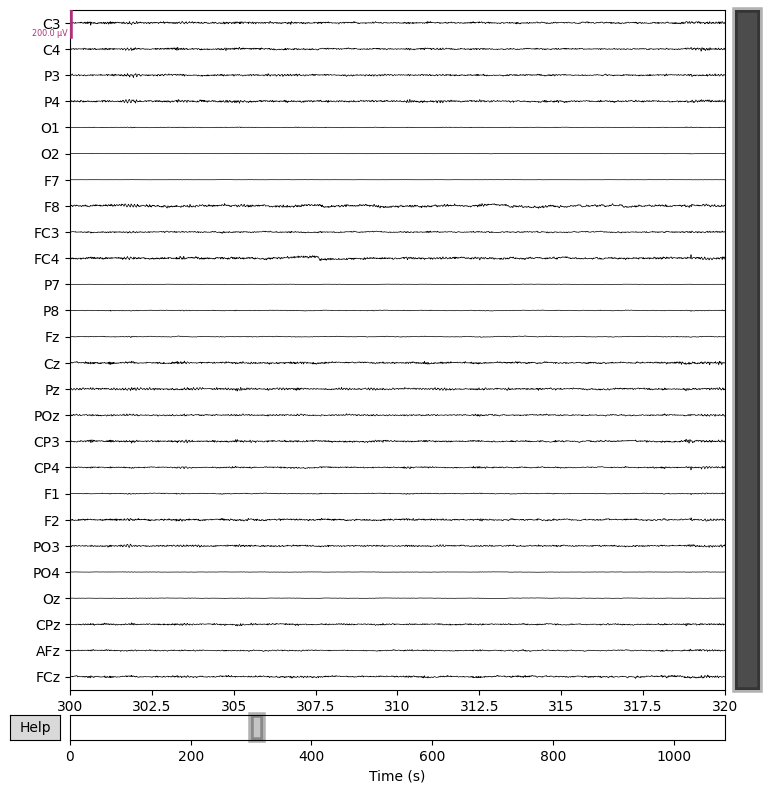

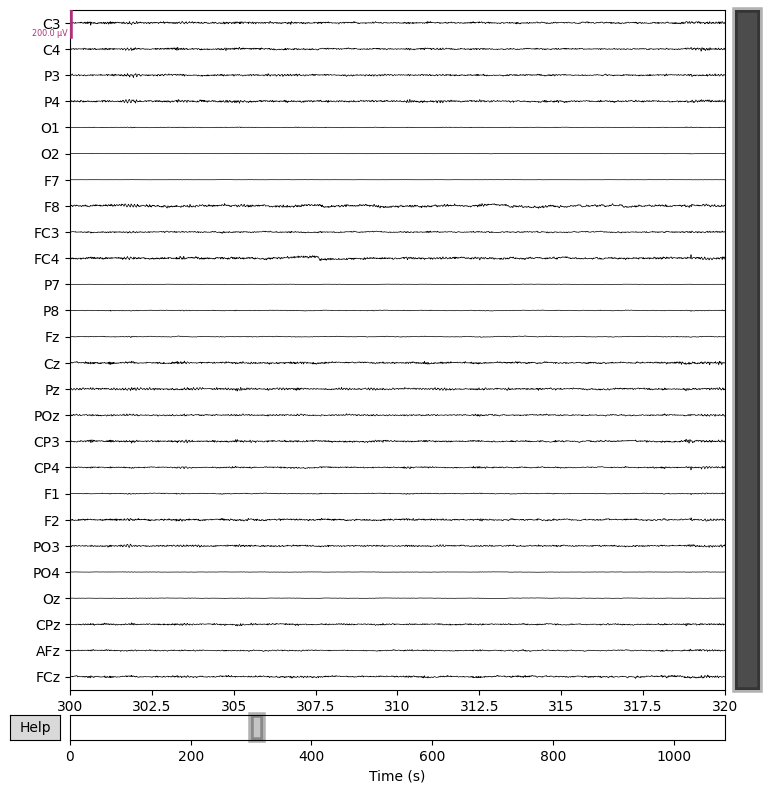

In [101]:
def apply_ica(ica, raw_data):
    cleaned_raw = raw_data.copy()
    ica.apply(cleaned_raw)
    
    # re-reference the data to the average of all EEG channels
    cleaned_raw.set_eeg_reference(ref_channels='average', ch_type='eeg')

    return cleaned_raw

print(f'Applying ICA for {filename}')
cleaned_raw = apply_ica(ica, raw)

%matplotlib inline
cleaned_raw.plot(start=300, n_channels=32, scalings={'eeg': 1e-4}, show=False, block=False, use_opengl=True, precompute=True, duration=20)

### Automated Bad Epoch Rejection

In [102]:
from autoreject import get_rejection_threshold, Ransac, AutoReject

def autoreject_epochs(raw):

    # Convert Raw to Epochs
    duration = 5.0
    epochs = mne.make_fixed_length_epochs(raw, duration=duration, preload=True)

    # RANSAC for bad channel detection
    ransac = Ransac(n_resample=50, min_channels=0.25, min_corr=0.85, 
                    unbroken_time=0.3, n_jobs=60, random_state=435656, 
                    picks=None, verbose=False)
    ransac.fit(epochs)
    ransac_bad_channels = ransac.bad_chs_

    if len(ransac_bad_channels) > 10:
        print(f"{len(ransac_bad_channels)} bad channels detected") #. Dropping segment.
        # return None  # or continue to next segment

    if len(ransac_bad_channels) > 0:
        print(f"Bad channels detected by RANSAC: {ransac_bad_channels}")
        epochs.info['bads'] += ransac_bad_channels
        epochs.interpolate_bads(reset_bads=True)

    # AutoReject
    reject = get_rejection_threshold(epochs, verbose=False)
    
    if len(epochs) < 10:
        print("Insufficient number of epochs. Skipping AutoReject.")
        return None  # or continue to next segment
     
    print(f'Fitting Autoreject for {filename}')

    ar = AutoReject(thresh_func=reject, random_state=42, cv=10, n_jobs=60, verbose=False)
    cleaned_epochs = ar.fit_transform(epochs)

    num_dropped_epochs = len(epochs) - len(cleaned_epochs)
    print(f"{num_dropped_epochs} of {len(epochs)} epochs dropped")

    return cleaned_epochs

cleaned_epochs_ar = autoreject_epochs(cleaned_raw)

from scipy.stats import zscore

def calculate_metrics(epochs):
    data = epochs.get_data()
    rms_values = np.sqrt(np.mean(data ** 2, axis=(1, 2)))
    snr_values = np.mean(data, axis=(1, 2)) / np.std(data, axis=(1, 2))
    
    # Calculate peak-to-peak values for each epoch
    ptp_values = np.max(data, axis=(1, 2)) - np.min(data, axis=(1, 2))

    return rms_values, snr_values, ptp_values

def drop_outlier_epochs(epochs, rms_values, snr_values, ptp_values, k=1, z_threshold=2, ptp_threshold=150):
    epochs = epochs.copy()
    
    initial_count = len(epochs)
    
    rms_threshold = np.mean(rms_values) + k * np.std(rms_values)
    snr_threshold = np.mean(snr_values) - k * np.std(snr_values)

    z_scores_rms = zscore(rms_values)
    z_scores_snr = zscore(snr_values)
    
    bad_epochs_rms = np.where(z_scores_rms > z_threshold)[0]
    bad_epochs_snr = np.where(z_scores_snr < -z_threshold)[0]
    bad_epochs_ptp = np.where(ptp_values > ptp_threshold)[0]
    
    bad_epochs = np.union1d(np.union1d(bad_epochs_rms, bad_epochs_snr), bad_epochs_ptp)

    epochs.drop(bad_epochs, reason='bad rms, snr, or ptp', verbose='ERROR')
    epochs_dropped_count = initial_count - len(epochs)
    
    return epochs, epochs_dropped_count > 0, epochs_dropped_count

def reject_outlier_epochs(epochs):
    
    # Calculate Metrics
    rms_values, snr_values, ptp_values = calculate_metrics(epochs)
    
    no_epochs = len(epochs)

    # Drop Bad Epochs based on calculated metrics
    cleaned_epochs, epochs_dropped, epochs_dropped_count = drop_outlier_epochs(
        epochs, rms_values, snr_values, ptp_values)
    
    print(f"{epochs_dropped_count} epochs out of {no_epochs} dropped based on bad rms, snr, or ptp values.")
    
    return cleaned_epochs

cleaned_epochs = reject_outlier_epochs(cleaned_epochs_ar)


21 bad channels detected
Bad channels detected by RANSAC: ['C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'FC4', 'P7', 'P8', 'Fz', 'Pz', 'POz', 'CP3', 'CP4', 'F2', 'PO4', 'Oz', 'CPz', 'AFz', 'FCz']
Fitting Autoreject for Imagine_Pre_4025_220424


C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mne\bem.py:1129: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


28 of 217 epochs dropped
13 epochs out of 189 dropped based on bad rms, snr, or ptp values.


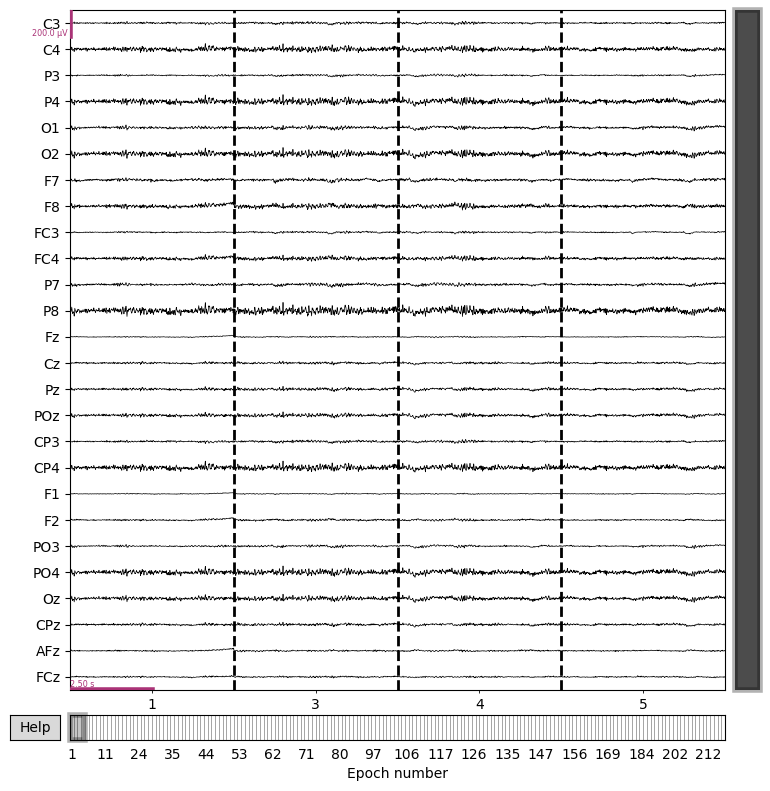

In [103]:
%matplotlib qt

cleaned_epochs.plot(n_channels=32, n_epochs=4, scalings={'eeg': 1e-4}, show=False, block=False, use_opengl=True, precompute=True) #

### Save Cleaned Data

In [104]:
import os

# Create 'preprocessed_data' folder if it doesn't exist
output_folder = os.path.join(os.getcwd(), 'preprocessed_data')
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Extract the original filename without extension
original_filename = os.path.basename(filepath).split('.')[0]

# Set output path
output_path = os.path.join(output_folder, f"{original_filename}-cleaned-epo.fif")

print(f'Saving cleaned_epochs for {filename}')
# Save cleaned_epochs
cleaned_epochs.save(output_path, overwrite=True)


Saving cleaned_epochs for Imagine_Pre_4025_220424
